# YOLO (You Only Look Once) Implementation for Traffic Assesment

## Prerequisites

#### Installing python dependencies

In [1]:
!pip install -r requirements.txt

#### Importing libraries

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
import matplotlib.patches as patches
import PIL
from PIL import Image
from xml.dom import minidom
import os
import random

tf.__version__

/media/data/Projects/programming/traffic-brain/classification/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/media/data/Projects/programming/traffic-brain/classification/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/media/data/Projects/programming/traffic-brain/classification/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _n

'1.14.0'

#### Listing availabel training devices

In [3]:
from tensorflow.python.client import device_lib
[x.name for x in device_lib.list_local_devices()]

['/device:CPU:0', '/device:XLA_CPU:0']

## Loading training/validation datasets

#### Defining images with which labels to be loaded

In [4]:
labels = {
    1: 'bicycle',
    2: 'bus',
    3: 'car',
    4: 'horse',
    5: 'motorbike',
    6: 'person',
    7: 'train'
}

#### Hyperparameters

In [5]:
RES = 448               # Image resolution
S = 7                   # Image square devisions
B = 2                   # Amount of bboxes to predict
C = len(labels) # Amount of classes
S, B, C

(7, 2, 7)

#### Defining a class for the annotated image data

In [6]:
class AnnotatedImage:
    class Object:
        def __init__(self, classs, bbox):
            self.classs = classs
            self.bbox = bbox

        def bbox_corner(self, side):
            if side == min:
                return (
                    self.bbox['x'] - self.bbox['w'] / 2,
                    self.bbox['y'] - self.bbox['h'] / 2)

            if side == max:
                return (
                    self.bbox['x'] + self.bbox['w'] / 2,
                    self.bbox['y'] + self.bbox['h'] / 2)
            
        def to_printable(self):
            return (self.classs, [bbox for bbox in self.bbox.values()])

    def __init__(self, name):
        self.name = name
        self.filepath = './data/VOCdevkit/VOC2012/JPEGImages/' + name + '.jpg'
        self.image = np.array(Image.open(self.filepath).resize((RES, RES), Image.ANTIALIAS), dtype=np.uint8)
        self.objects = self.__parse_objects()

    def __parse_objects(self):
        def __parse_object_coords(self, xmin, ymin, xmax, ymax):
            return {'x': (xmax + xmin)/2, 'y': (ymax + ymin)/2, 'w': xmax - xmin, 'h': ymax - ymin}

        document = minidom.parse('./data/VOCdevkit/VOC2012/Annotations/' + self.name + '.xml')
        xml_objects = document.getElementsByTagName('object')
        parsed_objects = []
        
        for xml_object in xml_objects:
            try:
                classs = list(labels.values()).index(xml_object.getElementsByTagName('name')[0].firstChild.nodeValue) + 1
            except:
                continue

            xml_bbox = xml_object.getElementsByTagName('bndbox')[0]
            width = int(document.getElementsByTagName('size')[0].getElementsByTagName('width')[0].firstChild.nodeValue)
            height = int(document.getElementsByTagName('size')[0].getElementsByTagName('height')[0].firstChild.nodeValue)

            parsed_objects.append(self.Object(
                classs=classs,
                bbox=__parse_object_coords(
                    self,
                    xmin = int(int(xml_bbox.getElementsByTagName('xmin')[0].firstChild.nodeValue)*(RES/width)),
                    ymin = int(int(xml_bbox.getElementsByTagName('ymin')[0].firstChild.nodeValue)*(RES/height)),
                    xmax = int(int(xml_bbox.getElementsByTagName('xmax')[0].firstChild.nodeValue)*(RES/width)),
                    ymax = int(int(xml_bbox.getElementsByTagName('ymax')[0].firstChild.nodeValue)*(RES/height)))
            ))

        return parsed_objects
    
    def to_printable(self):
            return (self.filepath, [object.to_printable() for object in self.objects])

#### Getting a list of all the train/val images of cars

In [7]:
# Loading all the filepaths in a list
train_images_filepaths = []
val_images_filepaths = []

for label in range(1, len(labels) + 1):
    train_file = open('./data/VOCdevkit/VOC2012/ImageSets/Main/' + labels[label] + "_train.txt", 'r')
    val_file = open('./data/VOCdevkit/VOC2012/ImageSets/Main/' + labels[label] + "_val.txt", 'r')
    for line in train_file:
        train_images_filepaths.append(line[:-4])
    for line in val_file:
        val_images_filepaths.append(line[:-4])
    
# Removing duplicate filepaths
train_images_filepaths = list(dict.fromkeys(train_images_filepaths))
val_images_filepaths = list(dict.fromkeys(val_images_filepaths))

'Number of images to be loaded: train - {}, val - {}'.format(len(train_images_filepaths), len(val_images_filepaths))

'Number of images to be loaded: train - 5717, val - 5823'

#### Loading the train/val images into separate array

In [8]:
train_images = []
val_images = []

for filename in train_images_filepaths[0:100]:
    train_images.append(AnnotatedImage(filename))

for filename in val_images_filepaths[0:80]:
    val_images.append(AnnotatedImage(filename))

#### Removing labels which are not going to be used

In [9]:
# for image in train_images:
#     for object in image.objects:
#         if object.name not in labels.values():
#             image.objects.remove(object)
    
# for image in val_images:
#     for object in image.objects:
#         if object.name not in labels.values():
#             image.objects.remove(object)

#### Resizing the images for a consistent model input shape

In [10]:
# for image in train_images:
#     image.image = np.array(image.image.resize((RES, RES), Image.ANTIALIAS), dtype=np.uint8)

# for image in val_images:
#     image.image = np.array(image.image.resize((RES, RES), Image.ANTIALIAS), dtype=np.uint8)

#### Testing whether the images & objects are loaded properly

('./data/VOCdevkit/VOC2012/JPEGImages/2008_000112.jpg', [])


<Figure size 432x288 with 0 Axes>

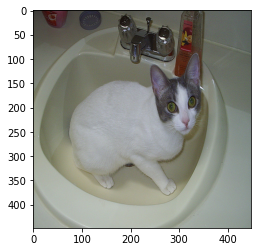

('./data/VOCdevkit/VOC2012/JPEGImages/2008_000097.jpg', [])


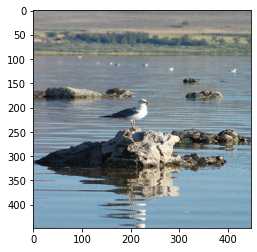

('./data/VOCdevkit/VOC2012/JPEGImages/2008_000074.jpg', [(3, [193.5, 306.0, 305, 188])])


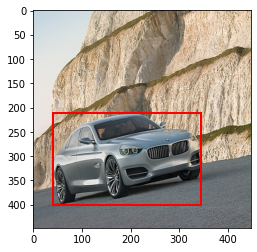

('./data/VOCdevkit/VOC2012/JPEGImages/2008_000346.jpg', [(6, [151.5, 224.5, 83, 289]), (3, [289.5, 274.5, 247, 239]), (3, [59.5, 231.5, 119, 229])])


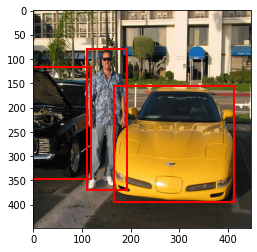

('./data/VOCdevkit/VOC2012/JPEGImages/2008_000316.jpg', [(6, [210.5, 280.5, 287, 335])])


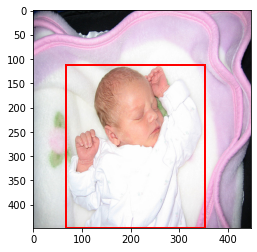

In [11]:
plt.figure()
for i in range(0, 5):
    rng = random.randint(1, len(train_images))
    fig, ax = plt.subplots(1)
    ax.imshow(train_images[rng].image)
    
    for object in train_images[rng].objects:
        rect = patches.Rectangle(
            (object.bbox_corner(min)),
            object.bbox_corner(max)[0] - object.bbox_corner(min)[0],
            object.bbox_corner(max)[1] - object.bbox_corner(min)[1],
            linewidth=2,
            edgecolor='#ff0000',
            facecolor='none'
        )
        ax.add_patch(rect)
        
    print(train_images[rng].to_printable())
    plt.show()

#### Formating image lables

In [12]:
def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])

In [13]:
train_labels = []
for i in train_images:
    label = [[[[[0 for i in range(5)] for i in range(B)], [0 for i in range(C)] ] for col in range(S)] for row in range(S)]
    for dim1 in range(S):
        for dim2 in range(S):
            ss = int(RES / S)
            for object in i.objects:                
#                 print((dim1 * ss in range(int(object.bbox_corner(min)[0]), int(object.bbox_corner(max)[0]))) or ((dim1 + 1) * ss in range(int(object.bbox_corner(min)[0]), int(object.bbox_corner(max)[0]))))
                if (((dim1 * ss in range(int(object.bbox_corner(min)[0]), int(object.bbox_corner(max)[0]))) and (dim2 * ss in range(int(object.bbox_corner(min)[1]), int(object.bbox_corner(max)[1])))) or ((dim1 + 1) * ss in range(int(object.bbox_corner(min)[0]), int(object.bbox_corner(max)[0])) and ((dim2 + 1) * ss in range(int(object.bbox_corner(min)[1]), int(object.bbox_corner(max)[1]))))):
                    label[dim1][dim2][1][object.classs - 1] = 1
            
                if int(object.bbox['x']) in range(dim1 * ss, (dim1 + 1) * ss) and int(object.bbox['y']) in range(dim2 * ss, (dim2 + 1) * ss):
                    for b, bbox_prediction in enumerate(label[dim1][dim2][0]):
                        if bbox_prediction[-1] == 0:
                            label[dim1][dim2][0][b] = [(object.bbox['x'] - dim1 * ss) / ss, (object.bbox['y'] - dim2 * ss) / ss, object.bbox['w'] / RES, object.bbox['h'] / RES, object.classs]
                            break
                            
            label[dim1][dim2] = flatten(label[dim1][dim2])
    train_labels.append(label)
    
train_labels = np.array(train_labels)

In [14]:
val_labels = []
for i in val_images:
    label = [[[[[0 for i in range(5)] for i in range(B)], [0 for i in range(C)] ] for col in range(S)] for row in range(S)]
    for dim1 in range(S):
        for dim2 in range(S):
            ss = int(RES / S)
            for object in i.objects:
                if (((dim1 * ss in range(int(object.bbox_corner(min)[0]), int(object.bbox_corner(max)[0]))) and (dim2 * ss in range(int(object.bbox_corner(min)[1]), int(object.bbox_corner(max)[1])))) or ((dim1 + 1) * ss in range(int(object.bbox_corner(min)[0]), int(object.bbox_corner(max)[0])) and ((dim2 + 1) * ss in range(int(object.bbox_corner(min)[1]), int(object.bbox_corner(max)[1]))))):
                    label[dim1][dim2][1][object.classs - 1] = 1

                if int(object.bbox['x']) in range(dim1 * ss, (dim1 + 1) * ss) and int(object.bbox['y']) in range(dim2 * ss, (dim2 + 1) * ss):
                    for b, bbox_prediction in enumerate(label[dim1][dim2][0]):
                        if bbox_prediction[-1] == 0:
                            label[dim1][dim2][0][b] = [(object.bbox['x'] - dim1 * ss) / ss, (object.bbox['y'] - dim2 * ss) / ss, object.bbox['w'] / RES, object.bbox['h'] / RES, object.classs]
                            break

            label[dim1][dim2] = flatten(label[dim1][dim2])
    val_labels.append(label)
    
val_labels = np.array(val_labels)

In [15]:
train_images = np.array([i.image for i in train_images], dtype='float32') / 255

In [16]:
val_images = np.array([i.image for i in val_images], dtype='float32') / 255

## Defining and training the neural network

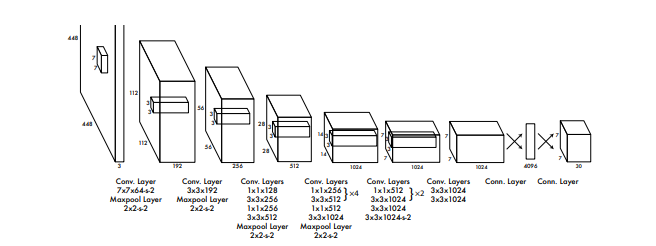

In [17]:
model = models.Sequential([
    layers.Conv2D(64, (S, S), strides=2, padding='same', activation='relu', input_shape=(448, 448, 3)),
    layers.MaxPooling2D((2, 2), input_shape=(224, 224, 64)),
    layers.Conv2D(192, (3, 3), strides=1, padding='same', activation='relu', input_shape=(112, 112, 64)),
    layers.MaxPooling2D((2, 2), input_shape=(112, 112, 192)),
    layers.Conv2D(128, (1, 1), strides=1, padding='same', activation='relu', input_shape=(56, 56, 192)),
    layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu', input_shape=(56, 56, 128)),
    layers.Conv2D(256, (1, 1), strides=1, padding='same', activation='relu', input_shape=(56, 56, 256)),
    layers.Conv2D(512, (1, 1), strides=1, padding='same', activation='relu', input_shape=(56, 56, 512)),
    layers.MaxPooling2D((2, 2), input_shape=(56, 56, 512)),
    layers.Conv2D(256, (1, 1), strides=1, padding='same', activation='relu', input_shape=(28, 28, 512)),
    layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu', input_shape=(28, 28, 256)),
    layers.Conv2D(256, (1, 1), strides=1, padding='same', activation='relu', input_shape=(28, 28, 512)),
    layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu', input_shape=(28, 28, 256)),
    layers.Conv2D(256, (1, 1), strides=1, padding='same', activation='relu', input_shape=(28, 28, 512)),
    layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu', input_shape=(28, 28, 256)),
    layers.Conv2D(256, (1, 1), strides=1, padding='same', activation='relu', input_shape=(28, 28, 512)),
    layers.Conv2D(512, (3, 3), strides=1, padding='same', activation='relu', input_shape=(28, 28, 256)),
    layers.Conv2D(512, (1, 1), strides=1, padding='same', activation='relu', input_shape=(28, 28, 512)),
    layers.Conv2D(1024, (3, 3), strides=1, padding='same', activation='relu', input_shape=(28, 28, 512)),
    layers.MaxPooling2D((2, 2), strides=2, padding='same', input_shape=(28, 28, 1024)),
    layers.Conv2D(512, (1, 1), strides=1, padding='same', activation='relu', input_shape=(14, 14, 1024)),
    layers.Conv2D(1024, (3, 3), strides=1, padding='same', activation='relu', input_shape=(14, 14, 512)),
    layers.Conv2D(512, (1, 1), strides=1, padding='same', activation='relu', input_shape=(14, 14, 1024)),
    layers.Conv2D(1024, (3, 3), strides=1, padding='same', activation='relu', input_shape=(14, 14, 512)),
    layers.Conv2D(1024, (3, 3), strides=1, padding='same', activation='relu', input_shape=(14, 14, 1024)),
    layers.Conv2D(1024, (3, 3), strides=2, padding='same', activation='relu', input_shape=(14, 14, 1024)),
    layers.Conv2D(1024, (3, 3), strides=1, padding='same', activation='relu', input_shape=(7, 7, 1024)),
    layers.Conv2D(1024, (3, 3), strides=1, padding='same', activation='relu', input_shape=(7, 7, 1024)),
    layers.Conv2D(1024, (3, 3), strides=1, padding='same', activation='relu', input_shape=(7, 7, 1024)),
    layers.Flatten(input_shape=(7, 7, 1024)),
    layers.Dense(4096, activation='relu', input_shape=(50176, )),
    layers.Dense(S * S * (B * 5 + C), activation='relu', input_shape=(4096, )),
    layers.Reshape((S, S, B * 25 + C), input_shape=(S * S * (B * 5 + C), ))
])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 192)     110784    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 192)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       24704     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 256)       295168    
____

In [18]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
checkpoint_path = "train_checkpont/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

p_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [20]:
print(train_images.shape)
print(train_labels.shape)
print(val_images.shape)
print(val_labels.shape)

(100, 448, 448, 3)
(100, 7, 7, 17)
(80, 448, 448, 3)
(80, 7, 7, 17)


In [21]:
train_labels[0]

array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0. 

In [22]:
detector = model.fit(
    train_images, train_labels, epochs=10, 
    validation_data=(
        val_images,
        val_labels)
)

Train on 100 samples, validate on 80 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10


InvalidArgumentError: Can not squeeze dim[3], expected a dimension of 1, got 17
	 [[{{node metrics/acc/Squeeze}}]]